## notebook for plotting the citation patterns of a single conference

revisions from v0:

* DONE - fix venue name entry: CoRR
* DONE - have venue name indicate conf or journal (-c, -j suffix) 
* DONE - clean up the data structure and groupbys 
* (no longer needed?) normalize heatmaps, compute entropy
* DONE export one single graph for incoming/outgoing citations
* DONE generate network layout for the graph above
* DONE - auto save and name the plots
* DONE - code to generate blog posts

processing

* figs for PLDI
* figs for ML conferences
* figs for ACM MM

* DONE new MAG data


In [50]:
import os, sys
import pandas as pd
from datetime import datetime 
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import json

# initilize plotting packages: seaborn

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

%matplotlib inline

#conf = 'MMSys'
conf = 'ICMR'
#conf = 'PLDI'
#conf = 'NIPS'
#conf = 'ACL'
#conf = 'MM'
data_dir = './data'

plot_dir = '/Users/xlx/SkyDrive/Repositories/cmLab/static/img/citation' #'./plots'
post_dir = '/Users/xlx/SkyDrive/Repositories/cmLab/content/citation'

if not os.path.exists(os.path.join(plot_dir, conf)):
    os.makedirs(os.path.join(plot_dir, conf))


input data: 

* dataframes: paper, citing, cited
* conference + journal --> df_venue, displaynames

In [51]:
d = pickle.load( open(os.path.join(data_dir, 'cite_records.'+conf+".pkl"), 'rb') )
# pickle.dump({"name":c, 'citing':dfx_citing, "cited":dfx_cited, "paper":df_paper}, 
#           open(os.path.join(data_dir, 'cite_records.'+c+".pkl"), 'wb') ) 

df_citing = d['citing']
df_cited = d['cited']
df_paper = d['paper']

print(len(df_paper), len(df_citing), len(df_cited))

423 4982 1066


In [52]:
conf_file = os.path.join(data_dir, 'Conferences.txt')
conf_df = pd.read_table(conf_file, header=None, names=['ConfID', 'Abbrv', 'FullName'])

jnl_file = os.path.join(data_dir, 'Journals.txt')
jnl_df = pd.read_table(jnl_file, header=None, names=['JournalID', 'FullName'])

print("{} conferences and {} journals found in db".format(len(conf_df), len(jnl_df)) )

num_conf = len(conf_df)

df_venue = pd.concat([ conf_df[['ConfID', 'Abbrv']].rename(columns = {'Abbrv':'VenueName', 'ConfID':"VenueID"}), 
                    jnl_df.rename(columns = {'FullName':'VenueName', 'JournalID':"VenueID"}, 
                                  index = dict(zip(list(jnl_df.index), [x+num_conf for x in list(jnl_df.index)])), 
                                  inplace=False) ], 
                    keys=['c', 'j'])

print( df_venue.head() ) 
print (df_venue.tail())
print(len(df_venue))

# find the id of the current conference
row = conf_df.loc[conf_df['Abbrv'] == conf]
conf_id = list(row['ConfID'])[0]

1283 conferences and 23404 journals found in db
      VenueID VenueName
c 0  42C0AB71      PAKM
  1  42DBFEF6       SWS
  2  42F4C8D1    ACIIDS
  3  4366C780      ICGI
  4  43742018      CTIC
          VenueID                                          VenueName
j 24682  3B5E5672                        Medicina Veterinaria-recife
  24683  3B6C2D0B                 Emj-engineering Management Journal
  24684  3B80ECF8  Eklem Hastaliklari Ve Cerrahisi-joint Diseases...
  24685  3D88A422                              Medicina-buenos Aires
  24686  3DCAB9BD                                Lecciones y Ensayos
24687


In [53]:
"""correct one acronym err as per discusion with Alex Wade at MSR -- 2016-02-24
Clinical Orthopaedics and Related Research  --> CoRR
"""

ifix = np.nonzero(df_venue['VenueName'] == "Clinical Orthopaedics and Related Research" )[0]
print("changing this entry: ")
print( df_venue.iloc[ ifix] ) 
print("to this entry: ")
df_venue.set_value(('j', ifix[0]), 'VenueName', 'CoRR')
print( df_venue.iloc[ifix] ) 


changing this entry: 
          VenueID                                   VenueName
j 19255  0B68DB42  Clinical Orthopaedics and Related Research
to this entry: 
          VenueID VenueName
j 19255  0B68DB42      CoRR


In [54]:
""" now generate dictionaries for display names: ID--> display; and VenueName--> display
"""
id2display = dict.fromkeys(list(df_venue['VenueID']))
name2display = dict.fromkeys(list(df_venue['VenueName']))

cnt = 0 
for index, row in df_venue.iterrows():
    v = row['VenueID']
    m = row['VenueName']
    m1 = m.replace('The Journal of', 'J.').replace('Journal of', 'J.').replace('Journal', 'J')
    m2 = m1.replace('Proceedings of', 'Proc.').replace('Proceedings', 'Proc')
    m3 = m2.replace('Annals of', 'A.').replace('Annals', 'A')
    m3 = m3.replace('Review', 'Rev').replace('Transactions', 'Trans')
    m3 = m3.replace('International', 'Intl').replace('National', 'Nat')
    m4 = m3 if len(m3)<=25 else m3[:23]+".."
    ds = m4+"-"+index[0]
    id2display[v] = ds
    name2display[m] = ds
    cnt += 1
    #if cnt>=24800: 
    #    print([v, m, ds])

In [55]:
print( df_paper.head() )
print( df_citing.head() )
print( df_cited.head() )

    PaperID                                          TitleOrig  \
0  79623698  A color-action perceptual approach to the clas...   
1  77DECB11  Gesture Interaction for Content--based Medical...   
2  75E79478  Multimodal Reranking of Content-based Recommen...   
3  796BFF42  Scalable Multimodal Search with Distributed In...   
4  761CED70          Saliency moments for image categorization   

                                           TitleNorm  PubYear     PubDate  \
0  a color action perceptual approach to the clas...     2011  2011/04/18   
1  gesture interaction for content based medical ...     2014  2014/04/01   
2  multimodal reranking of content based recommen...     2014  2014/04/01   
3  scalable multimodal search with distributed in...     2015  2015/06/22   
4          saliency moments for image categorization     2011  2011/04/18   

                       DOI                                         VenueOrig  \
0                      NaN  international conference on mult

In [56]:
refyear_citing = df_citing.groupby(['PaperPubYear', 'RefPubYear'], sort=True)
refyear_citing['RefID'].count()
print( np.unique(df_paper['PubYear'] ) ) 
print( np.unique(df_citing['PaperPubYear'] ) ) 
print( np.unique(df_citing['RefPubYear'] ) )

[2008 2011 2012 2013 2014 2015]
[2008 2011 2012 2013 2014 2015]
[1904 1908 1936 1937 1951 1955 1958 1962 1965 1967 1968 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988
 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]


In [57]:
paper_years = np.unique(df_citing['PaperPubYear'] )
paper_count = df_paper['PubYear'].value_counts(sort=False)[paper_years]

## filter out noise -- years w. # papers < 10
paper_years = list(filter(lambda y: paper_count[y] >= 10, paper_years)) 
paper_count = df_paper['PubYear'].value_counts(sort=False)[paper_years]

ref_pp = np.array( df_citing['PaperPubYear'].value_counts(sort=False)[paper_years]/paper_count )
cit_pp = np.array( df_cited['RefPubYear'].value_counts(sort=False)[paper_years]/paper_count )

print(paper_years)
print(paper_count.head())
print( ref_pp[:5])
print( cit_pp[:5])



[2011, 2012, 2013, 2014, 2015]
2011     77
2012     69
2013     66
2014     95
2015    115
Name: PubYear, dtype: int64
[ 13.42857143  13.47826087  10.81818182  14.08421053   8.32173913]
[ 5.85714286  3.88405797  2.74242424  1.64210526  0.08695652]


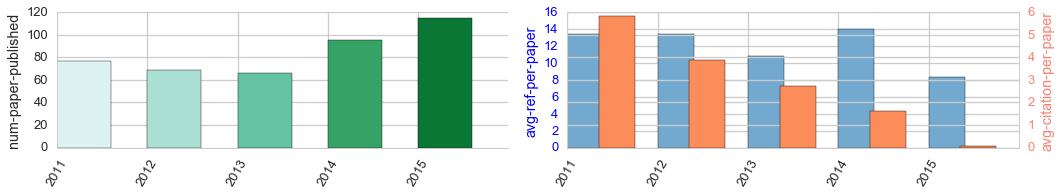

In [58]:
# data profile: # of papers published per year, citations per year

plt.figure(figsize=(15, 3))
cur_dpi=100
# # of papers over years; # of references and # of citations over years
# # of citings over years, w/wo venues; # of citing venues over years
# # of citations over publication years, w/wo venues; # of venues over years

bar_colrs1 = sns.color_palette("BuGn", len(paper_years))
bar_colrs2 = sns.color_palette("OrRd", len(paper_years))
bar_colrs3 = sns.color_palette("PuBu", len(paper_years))
mdx = int(len(bar_colrs1)/2) # index of the middle bar color
x_pos = [x+1 for x in range(len(paper_years))]

"""# papers per year"""

sns.set_context("talk", font_scale=1.)
sns.set_style("whitegrid")
sns.despine()

ax = plt.subplot(1, 2, 1)

rects1 = ax.bar(x_pos, np.array(paper_count), width=.6, color=bar_colrs1)
ax.set_ylabel('num-paper-published')
tk1 = plt.xticks(x_pos, paper_years, rotation=60) 

"""# of references and # of citations over years"""
ax2 = plt.subplot(1, 2, 2)

sns.set_style("whitegrid")
sns.despine()

rects2 = ax2.bar(x_pos, ref_pp, width=.4, color=bar_colrs3[mdx])

ax2a = ax2.twinx()
rects2a = ax2a.bar([x+.35 for x in x_pos], cit_pp, width=.4, color=bar_colrs2[mdx])

tk2 = plt.xticks([],[])
ax2.set_xticks(x_pos)
ax2.set_xticklabels(paper_years, rotation=60)

ax2.set_ylabel('avg-ref-per-paper', color='b')
ax2a.set_ylabel('avg-citation-per-paper', color='salmon')
for tl in ax2.get_yticklabels():
    tl.set_color('b')
for tl in ax2a.get_yticklabels():
    tl.set_color('salmon') 
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, conf, conf+'_cnt_paper.png'), dpi=cur_dpi, transparent=True)    

[3, 895, 834, 621, 1193, 880] [6, 139, 96, 93, 145, 77]


IndexError: list index out of range

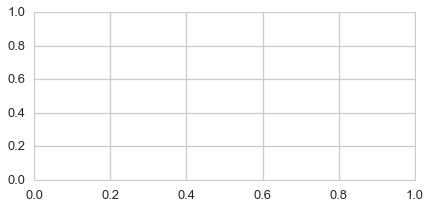

In [59]:
"""# of citings over years, w/wo venues; # of citing venues over years"""    
plt.figure(figsize=(15, 3))

ax3 = plt.subplot(1, 2, 1)
sns.set_context("talk", font_scale=1.)
sns.set_style("whitegrid")

citing_not_null = [] #np.zeros((1, len(years)), dtype=np.int)
citing_num_null = [] #np.zeros((len(years), 1), dtype=np.int)
cnt = 0 
for name, gf in df_citing.groupby(['PaperPubYear']):
    #print(gf.head())
    #print(len(gf), len ( gf['RefVenueID'][gf['RefVenueID'] != ''] ), len ( gf['RefVenueID'][gf['RefVenueID'] == ''] )) 
    citing_not_null.append( len ( gf['RefVenueID'][gf['RefVenueID'] != ''] ) )
    citing_num_null.append( len ( gf['RefVenueID'][gf['RefVenueID'] == ''] ) )
    
print(citing_not_null, citing_num_null)    
m1 = max(mdx+3, len(bar_colrs3)-1)
m2 = min(mdx-3, 0)
rects3a = ax3.bar(x_pos, citing_not_null, width=.6, color=bar_colrs3[m1])
rects3b = ax3.bar(x_pos, citing_num_null, width=.6, color=bar_colrs3[m2], bottom=citing_not_null)

tk3 = plt.xticks(x_pos, paper_years, rotation=60) 
ax3.set_ylabel('total-ref-per-year')
plt.legend((rects3a[0], rects3b[0]), 
           ('to known venues', 'to unknown venue'), bbox_to_anchor=(.45, 1))

ax4 = plt.subplot(1, 2, 2)
sns.set_style("whitegrid")

venue_counts = np.zeros( len(paper_years) )
for name, gf in df_citing[df_citing['RefVenueID'] != ''].groupby(['PaperPubYear']):
    idy = np.where(paper_years==name)
    if idy[0].size:
        venue_counts[idy] = len( gf['RefVenueID'].value_counts() )
    #venue_counts.append( len( gf['RefVenueID'].value_counts() ) )

rects4 = ax4.bar(x_pos, venue_counts, width=.6, color=bar_colrs3[mdx])

tk4 = plt.xticks(x_pos, paper_years, rotation=60)
ax4.set_ylabel('num-ref-venues')

plt.tight_layout()
plt.savefig(os.path.join(plot_dir, conf, conf+'_cnt_ref.png'), dpi=cur_dpi, transparent=True)    

[337, 206, 127, 134, 6] [114, 62, 54, 22, 4]
5 5


IndexError: list index out of range

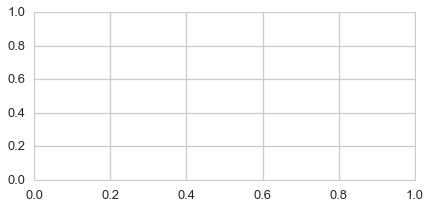

In [60]:
"""# of citations over publication years, w/wo venues; # of venues over years"""

plt.figure(figsize=(15, 3))

ax5 = plt.subplot(1, 2, 1)
sns.set_style("whitegrid")

citations_not_null = [0]*len(paper_years) 
citations_num_null = [0]*len(paper_years) 
for name, gf in df_cited.groupby(['RefPubYear']):
    #print(gf.head())
    # print(name, len(gf), len ( gf['PaperVenueID'][gf['PaperVenueID'] != ''] ), len ( gf['PaperVenueID'][gf['PaperVenueID'] == ''] )) 

    if name in paper_years:    
        idx = list(paper_years).index(name)
        citations_not_null[idx] = len ( gf['PaperVenueID'][gf['PaperVenueID'] != ''] ) 
        citations_num_null[idx] = len ( gf['PaperVenueID'][gf['PaperVenueID'] == ''] )
    
print(citations_not_null, citations_num_null)
print(len(citations_not_null), len(citations_num_null))


rects5a = ax5.bar(x_pos, citations_not_null, width=.6, color=bar_colrs2[m1])
rects5b = ax5.bar(x_pos, citations_num_null, width=.6, color=bar_colrs2[m2], bottom=citations_not_null)

tk5 = plt.xticks(x_pos, paper_years, rotation=60) 
ax5.set_ylabel('num-citations-per-year')
plt.legend((rects5a[0], rects5b[0]), 
           ('from known venues', 'from unknown venue'), bbox_to_anchor=(.45, 1))

ax6 = plt.subplot(1, 2, 2)
sns.set_style("whitegrid")

venue_counts = np.zeros( len(paper_years) )
for name, gf in df_cited[df_cited['PaperVenueID'] != ''].groupby(['RefPubYear']):
    idy = np.where(paper_years==name)
    if idy[0].size:
        venue_counts[idy] = len( gf['PaperVenueID'].value_counts() )
    #if name in paper_years:    
    #    venue_counts.append( len( gf['PaperVenueID'].value_counts() ) )

rects6 = ax6.bar(x_pos, venue_counts, width=.6, color=bar_colrs2[mdx])

tk6 = plt.xticks(x_pos, paper_years, rotation=60)
ax6.set_ylabel('num-citation-venues')
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, conf, conf+'_cnt_citation.png'), dpi=cur_dpi, transparent=True)    

423 paper papers from 2008 to 2015, citing 4982 others, avg 11.78 references per paper


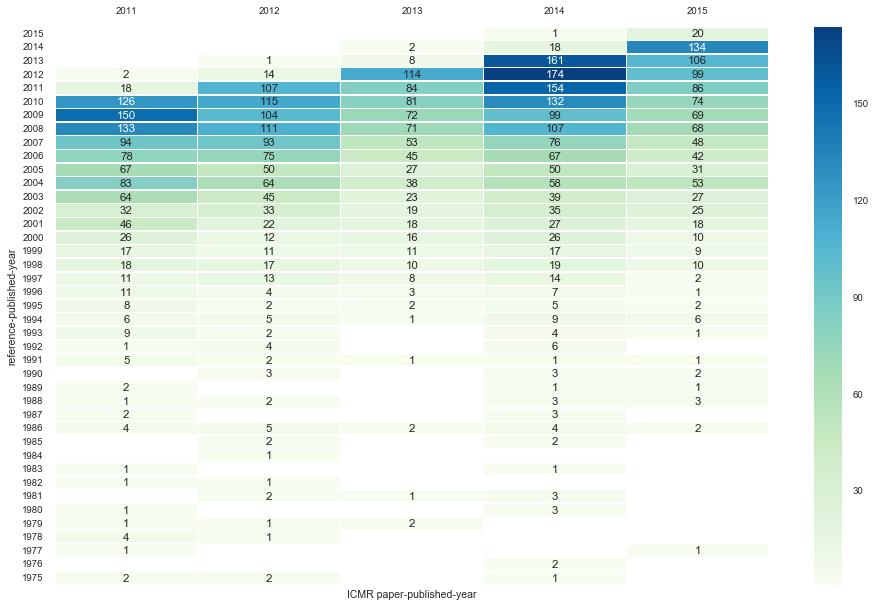

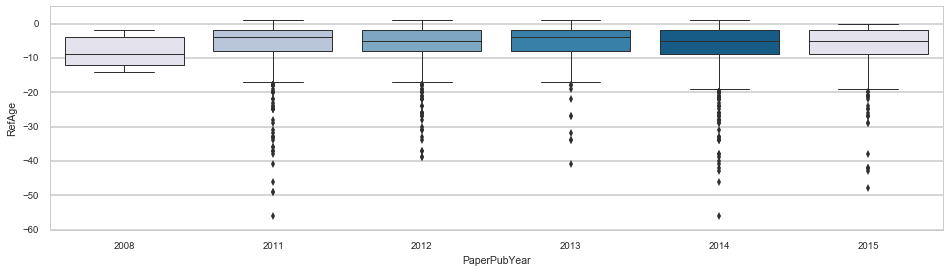

In [61]:
print('{} paper papers from {} to {}, citing {} others, avg {:0.2f} references per paper'.format(
        len(df_paper), df_paper['PubYear'].min(), df_paper['PubYear'].max(), len(df_citing), len(df_citing)/len(df_paper)))
grouped_citing = df_citing.groupby(['PaperPubYear'], sort=True)
grouped_citing.count()
len(grouped_citing)

refpubyear_count = pd.DataFrame(data=None, index=np.unique(df_citing['RefPubYear'] ), 
                                    columns=paper_years, dtype='int32')
for name, gf in grouped_citing:
    if name in paper_years:    
        refpubyear_count[name] = gf['RefPubYear'].value_counts(sort=True)
    #print("{}: {} references across {} years".format(name, len(gf), len(gf['RefPubYear'].value_counts())) )

plt.figure(figsize=(16, 10))
sns.set_context("poster", font_scale=0.6) #rc={"lines.linewidth": 2.5}

""" # the view of everthing
sns.heatmap(refpubyear_count, linewidths=.5, yticklabels=3)
ax.xaxis.tick_top()
ax.invert_yaxis()
sns.axlabel(conf + ' paper-published-year', 'reference-published-year')
"""

# the subset of reference years
ax = sns.heatmap(refpubyear_count.loc[1975:2015], linewidths=.5, annot=True, fmt=".0f", cmap="GnBu")
ax.xaxis.tick_top()
ax.invert_yaxis()
sns.axlabel(conf + ' paper-published-year', 'reference-published-year')

plt.savefig(os.path.join(plot_dir, conf, conf+'_year_ref.png'), transparent=True)

""" # box plot of the age of paper being cited 
dataframe:  df_citing
y: RefPubYear
y: ref age (paperpubyear - refpubyear)
x (group by): PaperPubYear   
"""
plt.figure(figsize=(16, 4))
df_citing['RefAge'] = - df_citing['PaperPubYear'] + df_citing['RefPubYear']
axb = sns.boxplot(x="PaperPubYear", y="RefAge", data=df_citing, 
                 linewidth=1., palette=bar_colrs3)
ylim = axb.get_ylim()
axb.set_ylim([max(-60, ylim[0]), min(5, ylim[1])])
plt.savefig(os.path.join(plot_dir, conf, conf+'_box_ref.png'), transparent=True)

In [62]:
print('{} paper papers from {} to {}, cited {} time, avg {:0.2f} cites per paper'.format(
        len(df_paper), df_paper['PubYear'].min(), df_paper['PubYear'].max(), len(df_cited), len(df_cited)/len(df_paper)))

grouped_cited = df_cited.groupby(['RefPubYear'], sort=True)
#print( grouped_cited.count() )
#len(grouped_cited)

cite_pubyear_count = pd.DataFrame(data=0, index=np.unique(df_cited['PaperPubYear'] ), 
                                    columns=paper_years, dtype='int')
cite_paper_count = pd.DataFrame(data=0, index=np.unique(df_cited['PaperPubYear'] ), 
                                    columns=paper_years, dtype='int')
cite_fraction_count = pd.DataFrame(data=np.nan, index=np.unique(df_cited['PaperPubYear'] ), 
                                    columns=paper_years, dtype='float')

cite_yearange = np.arange(1975,2016)

for name, gf in grouped_cited:
    if name in paper_years:    
        cite_pubyear_count[name] = gf['PaperPubYear'].value_counts(sort=True)
        group2 = gf.groupby(['PaperPubYear'], sort=True)
        for py, gf2 in group2:
            if py in cite_yearange:
                cite_paper_count[name][py] = len(np.unique(gf2['RefID'])) # unique number of RefID, or papers being cited
                if paper_count[name] > 0:
                    cite_fraction_count[name][py] = 1.*cite_paper_count[name][py]/paper_count[name] # fraction papers cited


423 paper papers from 2008 to 2015, cited 1066 time, avg 2.52 cites per paper


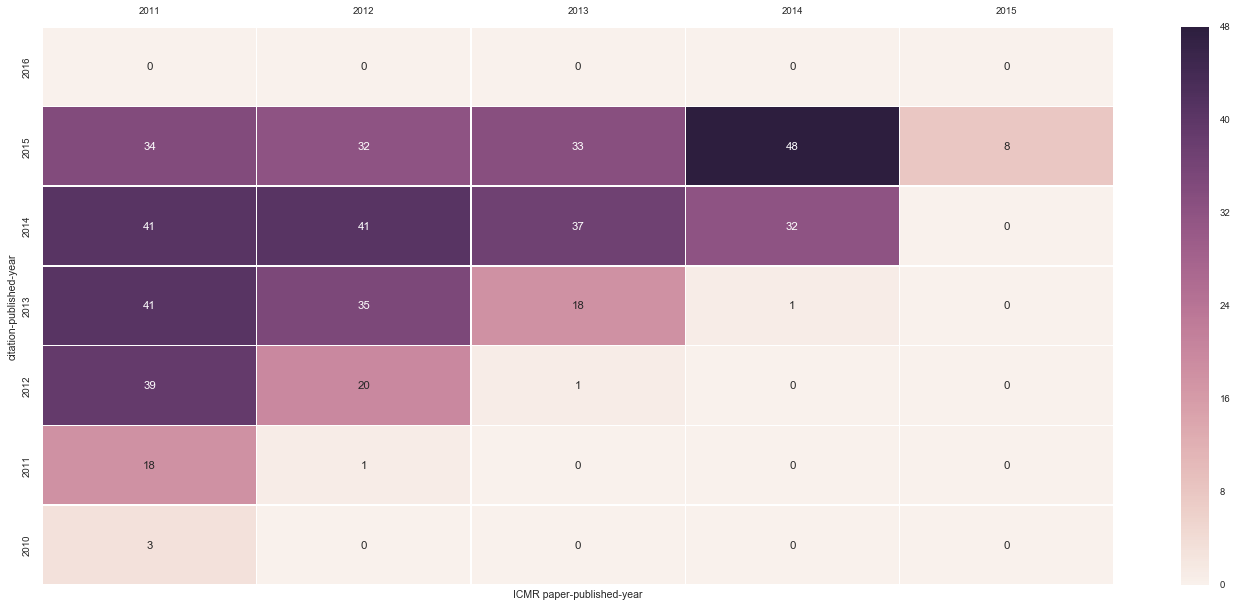

In [63]:
plt.figure(figsize=(24, 10))
sns.set_context("poster", font_scale=0.6) #rc={"lines.linewidth": 2.5}

#ax = sns.heatmap(cite_pubyear_count.tail())
#ax = sns.heatmap(cite_pubyear_count.loc[1975:2016], linewidths=.5, annot=True, fmt=".0f")
ax = sns.heatmap(cite_paper_count.loc[1975:2016], linewidths=.5, annot=True, fmt=".0f")
sns.axlabel(conf + ' paper-published-year', 'citation-published-year')
ax.xaxis.tick_top()
ax.invert_yaxis()

plt.savefig(os.path.join(plot_dir, conf, conf+'_year_citation.png'), transparent=True)


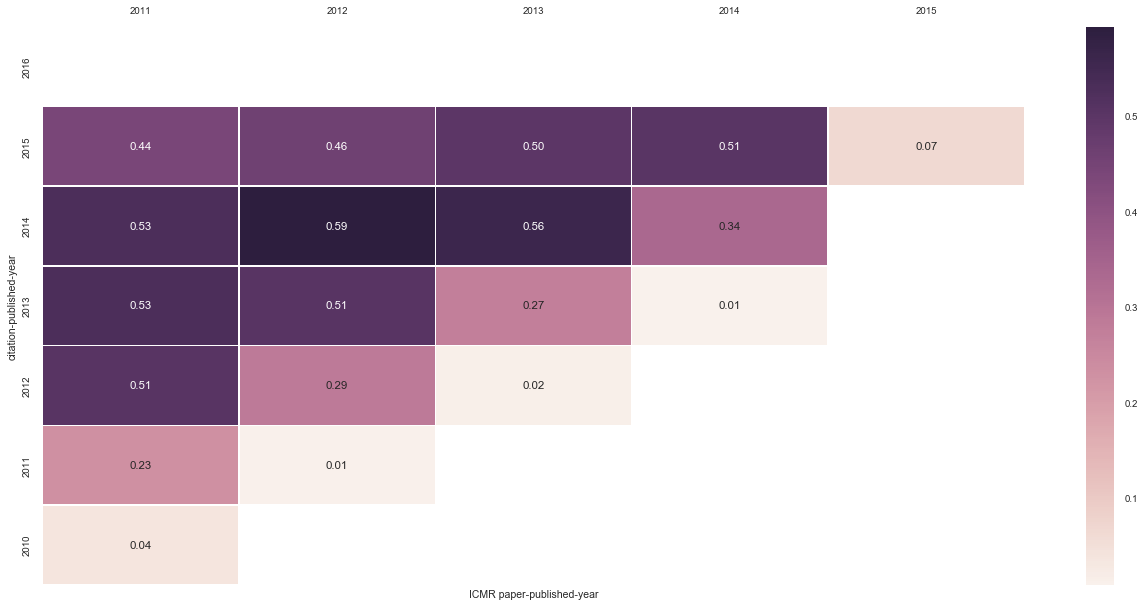

In [64]:
plt.figure(figsize=(22, 10))
sns.set_context("poster", font_scale=0.6) #rc={"lines.linewidth": 2.5}

ax = sns.heatmap(cite_fraction_count.loc[1975:2016], linewidths=.5, annot=True, fmt=".2f")

sns.axlabel(conf + ' paper-published-year', 'citation-published-year')
ax.xaxis.tick_top()
ax.invert_yaxis()
#plt.title('fraction of papers cited by pub+citation years', loc="bottom")

plt.savefig(os.path.join(plot_dir, conf, conf+'_year_frac.png'), transparent=True)

Citation survival rates: 0yr 0.70; 10yr nan; 20yr nan.


,gap,num_cited,num_papers,cite_rate
0,0,214,307,0.697068
1,1,156,212,0.735849
2,2,102,146,0.698630
3,3,51,77,0.662338
4,4,0,0,NaN
5,5,0,0,NaN
6,6,0,0,NaN
7,7,0,0,NaN
8,8,0,0,NaN
9,9,0,0,NaN


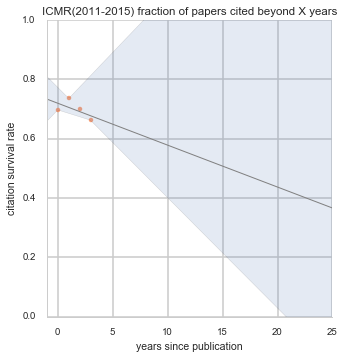

In [65]:
# try to produce the 'citation survival rate' figure 
max_gap = 21
num_cited = [0.]*max_gap
num_paper_norm = [0]*max_gap # num of papers published that could have the designated gap

for pub_year, gf in grouped_cited: #grouped by ref pub_year
    if pub_year in paper_years: 
        for gap in range(min(max_gap, max(paper_years)- pub_year)) :
            from_year = pub_year + gap
            #cur_cnt = cite_paper_count[pub_year].loc[from_year:].sum() # this is wrong
            cur_cnt = len( gf[gf['PaperPubYear']>=from_year]['RefID'].unique() )
            num_cited[gap] += cur_cnt
            #if cur_cnt>0:
            num_paper_norm[gap] += paper_count[pub_year]
            # code from Jacob
            #num_cited[gap] += len(df[(df['to_year']==to_year) & (df['from_year']>from_year)]['to'].unique())
            #num_papers[gap] += papers_per_year[to_year]

df_survive = pd.DataFrame({'gap':range(max_gap),'num_papers':num_paper_norm,'num_cited':num_cited})
df_survive['cite_rate'] = df_survive['num_cited']/df_survive['num_papers']

plt.figure(figsize=(12, 6))
ax = sns.lmplot(x='gap', y='cite_rate', data=df_survive, 
                line_kws={'c':'0.5', 'lw':1, 'ls':'solid'}, scatter_kws={'c':bar_colrs2[mdx]})
ax.set_ylabels('citation survival rate')
ax.set_xlabels('years since publication');
yrstr = "({}-{})".format(paper_years[0], paper_years[-1])
plt.title(conf + yrstr + ' fraction of papers cited beyond X years')
plt.gca().set_ylim(0., 1.)
plt.gca().set_xlim(-1, max_gap+4)

plt.savefig(os.path.join(plot_dir, conf, conf+'_citation_survival.png'), transparent=True)
plt.savefig(os.path.join(plot_dir, conf, conf+'_citation_survival.pdf'), transparent=True)

print("Citation survival rates: 0yr {:.2f}; 10yr {:.2f}; 20yr {:.2f}.".format(
        df_survive['cite_rate'][0], df_survive['cite_rate'][10], df_survive['cite_rate'][20]))
df_survive

In [66]:
""" refs and citation data frames
PaperID     RefID  PaperPubYear  PaperConfID  RefPubYear RefVenueID
0  01C7AF88  5DF47FD5          2014      4332078        2005           
1  0419D273  69802989          2013      4332078        1983           
2  04C8255A  707FA05D          2011      4332078        2008   46A355BA
3  06E27F4E  5D781F7D          2014      4332078        2000    5686292
4  07E16ECA  5ACD83EA          2012      4332078        2005   4332078E

PaperID     RefID  RefPubYear  RefConfID  PaperPubYear PaperVenueID
0  0007A307  6F46CC0D        2000    4332078          2003             
1  001D62B0  5C4CC440        2002    4332078          2014     0140E2D3
2  002545D4  685D7FC2        1999    4332078          2005             
3  002E73A6  6978437E        2007    4332078          2009             
4  004344D3  5CCE3A13        1990    4332078          1991             

goal of this sec: groupby venue and count
"""

topK = 25 #50 
numRef = len(df_citing)
numCite = len(df_cited)

# figure out the top venues for both ref and citations
gv_citing = df_citing.groupby(['RefVenueID'], sort=True)
venue_ref_cnt = gv_citing['PaperID'].count().sort_values(ascending=False)
allvenue_ref = [s for s in venue_ref_cnt.index if len(s)]

gv_cited = df_cited.groupby(['PaperVenueID'], sort=True)
venue_citation_cnt = gv_cited['PaperID'].count().sort_values(ascending=False)
allvenue_citation = [s for s in venue_citation_cnt.index if len(s)]

venue_topK = list(set(allvenue_ref[:topK] + allvenue_citation[:topK]))
print('{} top-{} venues, union of reference and citations.'.format(len(venue_topK), topK) )

# build a graph structure for the above

venueG = nx.DiGraph()
refG = nx.DiGraph()
citeG = nx.DiGraph()

venue_metric = dict()
venue_ref = dict()
venue_citation = dict()

"""
    construct venue graphs, and 
    compute the in/out citation metric 
"""
for v in venue_topK:
    vname = id2display[v]
    r = venue_ref_cnt[v] if v in venue_ref_cnt else 1
    refG.add_edge(conf, vname, weight= int(r) )
    venueG.add_edge(conf, vname, weight= float(r/numRef) )
    
    c = venue_citation_cnt[v] if v in venue_citation_cnt else 1
    citeG.add_edge(vname, conf, weight= int(c) )
    venueG.add_edge(vname, conf, weight= float(c/numCite) )
    
    # visualization and meta attributes 
    venue_ref[vname] = float(r) #float(r/numRef)
    venue_citation[vname] = float(c) #float(c/numCite)
    venue_metric[vname] = float(r)/c #float(r/numRef) / float(c/numCite)

nx.set_node_attributes(venueG, 'citation_out', venue_ref)
nx.set_node_attributes(venueG, 'citation_in', venue_citation)
nx.set_node_attributes(venueG, 'citation_flow', venue_metric)

#nx.write_graphml(venueG, os.path.join(data_dir, 'citeG.'+conf+'.graphml'))
#nx.write_gexf(venueG, os.path.join(data_dir, 'citeG.'+conf+'.gexf'))



37 top-25 venues, union of reference and citations.


2.12385164097 714.0 111.0 736.0


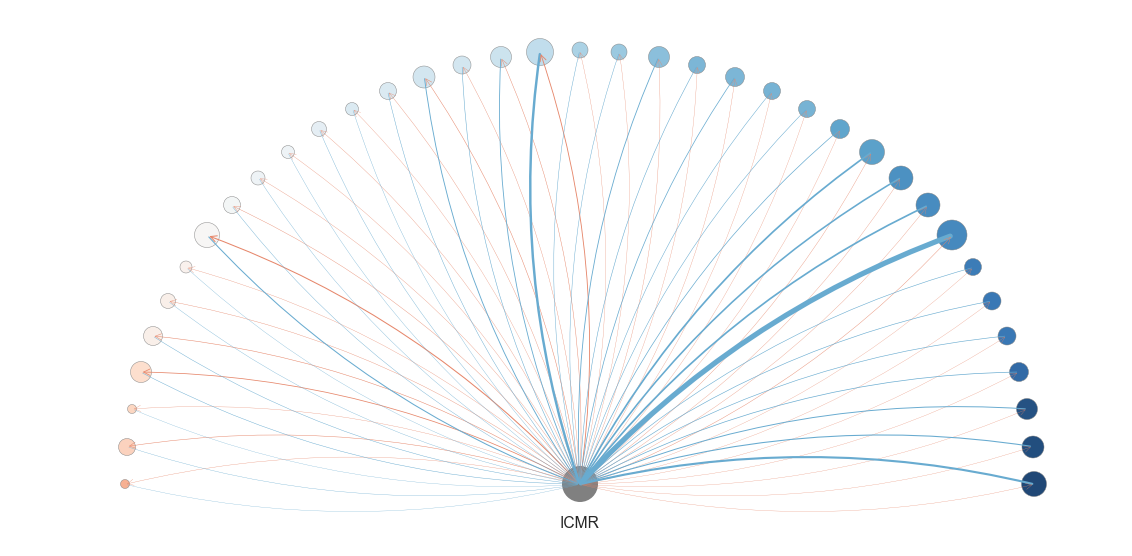

In [67]:
# plot the above info as a graph with curved edges
#import matplotlib.patches as mpatches
from matplotlib import gridspec

fig = plt.figure(figsize=(16, 8))
sns.set_context("talk", font_scale=1.)
sns.set_style("white")
sns.despine()
ax = fig.add_subplot(111)

max_marker = 30
max_line = 5.
min_line = 0.25

num_clrs = 100
dot_colors = sns.color_palette("RdBu", num_clrs)
out_edge_color = dot_colors[round(3*num_clrs/4)] #{'r':32, 'g':32, 'b':192}
in_edge_color = dot_colors[round(1*num_clrs/4)] #{'r':192, 'g':32, 'b':32}

metric_max = max( [np.abs(np.log10(v)) for v in venue_metric.values()] )
ref_max = max( venue_ref.values() )
cite_max = max( venue_citation.values() )
vol_max = max( [r+c for (r, c) in zip(venue_ref.values(), venue_citation.values())] )
delta_text = 0.02 

print(metric_max, ref_max, cite_max, vol_max)

# plot the root node
#node_viz[conf] = {'size': flowmax*1.25, 'position':{'x': 0, 'y':0, 'z':0}}
xroot = 0.
yroot = 0.
ax.plot(xroot, yroot, 'o', c=[.5, .5, .5], markersize=1.2*max_marker, fillstyle='full', mec='0.5')
ax.text(xroot, yroot-5*delta_text, conf, horizontalalignment='center')
#ax.annotate(conf, xy=(0, 0), xytext=(0, -.1), horizontalalignment='left',
#            verticalalignment='bottom')

# generate the layout and plot
isort = list(np.argsort([venue_metric[id2display[v]] for v in venue_topK]))
anglelist = np.linspace(np.pi, 0., num=len(isort))
h_txt = []
for i,j in enumerate(isort):
    v = venue_topK[j]
    vn = id2display[v]
    xp = np.cos(anglelist[i]) #np.log10(venue_metric[vn])/metric_max
    yp = np.sin(np.abs(anglelist[i])) # np.random.random() 
    
    # figure out what color and size of the node
    sz = np.round( max_marker * np.log(venue_ref[vn]+venue_citation[vn])/np.log(vol_max) )
    ci = np.log10(venue_metric[vn]-1e-3)/metric_max * num_clrs/2 + num_clrs/2
    #print(anglelist[i], xp, yp, sz, ci, int(ci) )
    
    # figure out width of the lines
    in_lw = max_line * venue_ref[vn]/ref_max + min_line
    out_lw = max_line * venue_citation[vn]/ref_max + min_line
    
    # draw connectors/arcs
    ax.annotate("", xy=(xroot, yroot), xycoords='data',
            xytext=(xp, yp), textcoords='data',
            arrowprops=dict(arrowstyle="-", #linestyle="dashed",
                            color=out_edge_color, linewidth=in_lw,
                            connectionstyle="arc3,rad=0.12", ), )

    ax.annotate("", xy=(xp, yp), xycoords='data',
            xytext=(xroot, yroot), textcoords='data',
            arrowprops=dict(arrowstyle="->", #linestyle="dashed",
                            color=in_edge_color, linewidth=out_lw,
                            connectionstyle="arc3,rad=0.12",),)

    # draw the node
    ax.plot(xp, yp, 'o', c=dot_colors[int(ci)], markersize=int(sz), 
            alpha=.9, mec='0.5', mew=.5) 

    
    # add text labels
    if np.abs(xp)>1e-6 and np.abs(xp)<0.2 :
        yt = yp + .3*delta_text/np.abs(xp)
    else:
        yt = yp + delta_text

    if np.abs(xp)<1e-6:
        xt = xp 
        yt = yp + 5*delta_text
        halign = 'left'
    elif xp>0:
        xt = xp + delta_text
        halign = 'left'
    else:
        xt = xp - delta_text
        halign = 'right'
    
    h = ax.text(xt, yt, vn, horizontalalignment=halign)
    h_txt.append(h)

ax.set_xlim((-1.2, 1.2))
ax.set_ylim((-.1, 1.1))
ax.axis('off')

plt.savefig(os.path.join(plot_dir, conf, conf+'_graph.png'), dpi=cur_dpi, transparent=True)
plt.savefig(os.path.join(plot_dir, conf, conf+'_graph.pdf'), dpi=cur_dpi, transparent=True)

for h in h_txt:
    h.remove()
plt.tight_layout()    
plt.savefig(os.path.join(plot_dir, conf, conf+'_mini_graph.png'), dpi=cur_dpi/2.5, transparent=True)

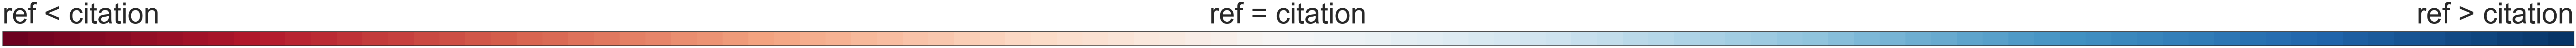

In [68]:
fig = plt.figure(figsize=(6, 2))
sns.palplot(dot_colors)
axt = plt.gca()
xm = axt.get_xlim()
axt.text(xm[-1], -1.1, 'ref > citation', fontsize=80, horizontalalignment='right')
axt.text(xm[0], -1.1, 'ref < citation', fontsize=80, horizontalalignment='left')
axt.text(.5*(xm[0]+xm[-1]), -1.1, 'ref = citation', fontsize=80, horizontalalignment='center')

plt.tight_layout()
plt.savefig(os.path.join(plot_dir, conf, 'color_bar.png'), dpi=cur_dpi/2, transparent=True)



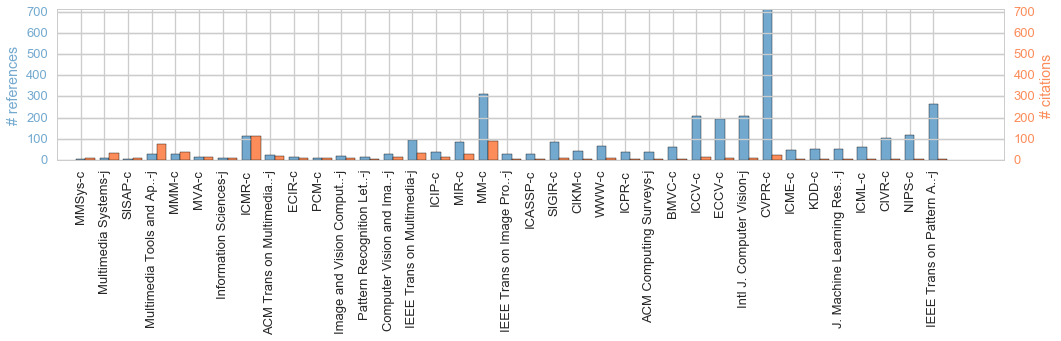

In [69]:
# generate bar graphs visualizing overall in/out citation volume
plt.figure(figsize=(15, 5))
sns.set_context("talk", font_scale=1.) #rc={"lines.linewidth": 2.5}
sns.set_style("whitegrid")
sns.despine()

isort = list(np.argsort([venue_metric[id2display[v]] for v in venue_topK]))
sorted_name_list = [id2display[venue_topK[i]] for i in isort]
x_venues = [x+1 for x in range(len(venue_topK))]

ax2 = plt.subplot(1,1,1)

vbar = ax2.bar([x-.2 for x in x_venues], [venue_ref[v] for v in sorted_name_list], 
                width=.4, color=bar_colrs3[mdx])
ax2.set_ylim([0, max([cite_max, ref_max])])

ax2a = ax2.twinx()
vbara = ax2a.bar([x+.2 for x in x_venues], [venue_citation[v] for v in sorted_name_list], 
                   width=.4, color=bar_colrs2[mdx])
ax2a.set_ylim([0, max([cite_max, ref_max])])

tk2 = plt.xticks([],[])
ax2.set_xticks(x_venues)
ax2.set_xticklabels(sorted_name_list, rotation=90)

ax2.set_ylabel('# references', color=bar_colrs3[mdx])
ax2a.set_ylabel('# citations', color=bar_colrs2[mdx])
for tl in ax2.get_yticklabels():
    tl.set_color(bar_colrs3[mdx])
for tl in ax2a.get_yticklabels():
    tl.set_color(bar_colrs2[mdx]) 
plt.tight_layout()

plt.savefig(os.path.join(plot_dir, conf, conf+'_venue_bar.png'), dpi=cur_dpi, transparent=True)

In [70]:
# accumulate counts for refrences
refvenue_count = pd.DataFrame(data=None, dtype='int32', index = allvenue_ref, columns = paper_years)

for name, gf in grouped_citing:
    if name in paper_years:    
        refvenue_count[name] = gf['RefVenueID'].value_counts(sort=True)


# accumulate counts for citations
citevenue_count = pd.DataFrame(data=None, index = allvenue_citation, columns = paper_years, dtype='int32')
for name, gf in grouped_cited:
    if name in paper_years:    
        citevenue_count[name] = gf['PaperVenueID'].value_counts(sort=True)
    

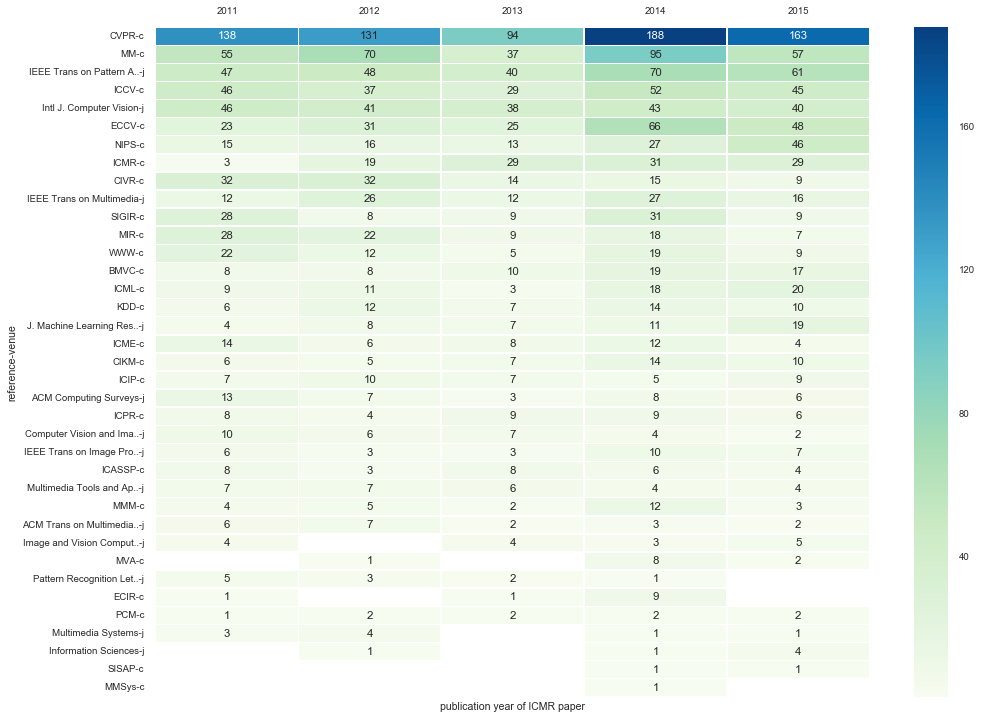

In [71]:
# amount of references over time 
plt.figure(figsize=(16, 12))
sns.set_context("poster", font_scale=0.6)

jsort = list(np.argsort([venue_ref[id2display[v]] for v in venue_topK]))
jsort.reverse()
sorted_vlist = [id2display[venue_topK[j]] for j in jsort]
sorted_vid = [venue_topK[j] for j in jsort]

ax = sns.heatmap(refvenue_count.loc[sorted_vid], linewidths=.5, annot=True, fmt=".0f", cmap="GnBu") 
ax.xaxis.tick_top()
sns.axlabel('publication year of ' + conf + ' paper', 'reference-venue')

yt = ax.set_yticklabels(sorted_vlist[::-1])

plt.savefig(os.path.join(plot_dir, conf, conf+'_venue_ref.png'), transparent=True)

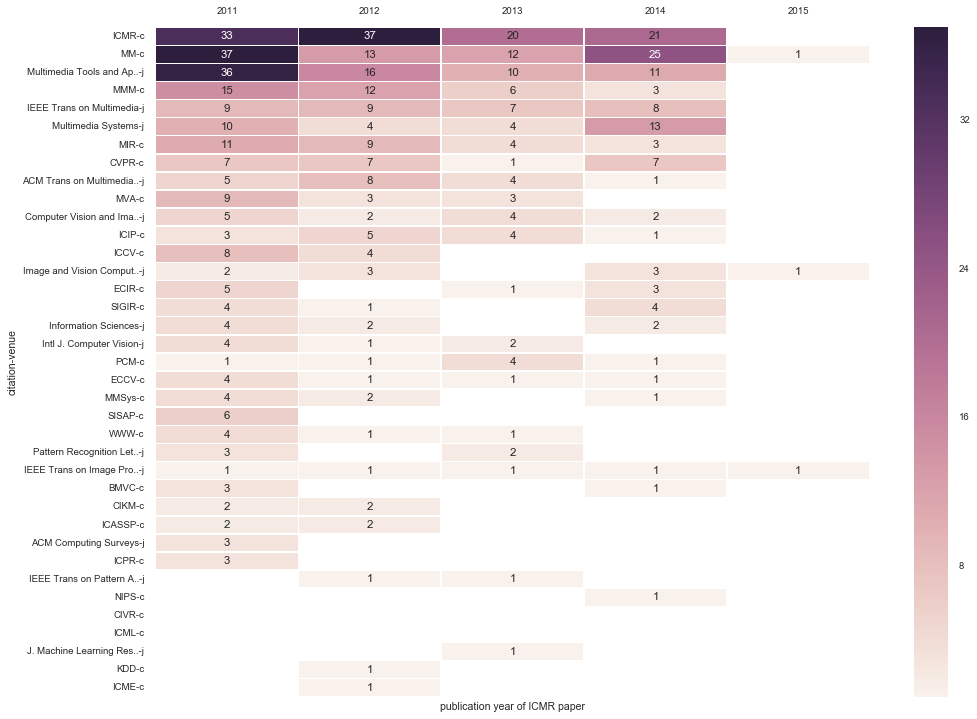

In [72]:
# amount of citations over time 
plt.figure(figsize=(16, 12))
sns.set_context("poster", font_scale=0.6)

jsort = list(np.argsort([venue_citation[id2display[v]] for v in venue_topK]))
jsort.reverse()
sorted_vlist = [id2display[venue_topK[j]] for j in jsort]
sorted_vid = [venue_topK[j] for j in jsort]

ax = sns.heatmap(citevenue_count.loc[sorted_vid], linewidths=.5, annot=True, fmt=".0f") 
ax.xaxis.tick_top()
sns.axlabel('publication year of ' + conf + ' paper', 'citation-venue')

yt = ax.set_yticklabels(sorted_vlist[::-1])

plt.savefig(os.path.join(plot_dir, conf, conf+'_venue_citation.png'), transparent=True)

In [73]:
## code to write markdown posts

""" 
name of the post file, and couple of other variables
"""

post_file = os.path.join(post_dir, conf+".md")
img_path = "/img/citation"
conf_full_name = list(conf_df["FullName"][conf_df['Abbrv']==conf])[0]
img_width = 900

ph = open(post_file, "wt")

"""  write header for the post
---
title: "Media and News"
description: "An archive of what others and ourselves think are news-worthy."
date: "2016-01-02"
categories:
  - "misc"
tags:
  - "cm"
---
"""
page_title = "{} - {} ({}-{})".format(conf, conf_full_name, paper_years[0], paper_years[-1])

ph.write("---\n")
ph.write('title: "{}"\n'.format(page_title))
ph.write('description: "Citation pattern stats and plots for this conference."\n'.format(conf, conf_full_name))
ph.write('date: "{}"\n'.format(datetime.now()))
ph.write('categories:\n  - "data"\n  - "visualization"\n')
ph.write('tags:\n  - "citation"\n  - "datasci"\n  - "graph"\n')
ph.write("---\n\n")

""" overview image and its legend
<div style="float:left; position: relative; width:320px; height:200px">
  <a href=#fig4><img src="/img/citation/ICAPS/ICAPS_mini_graph.png" style="position: relative; top: 0; left: 0;" width="320"/></a>
  <img src="/img/citation/mini_bar.png" style="position: absolute; top: 160px; left: 30px;"/>
</div>
"""
ph.write('<div style="float:left; position: relative; width:800px; height:280px">')
ph.write('  <a href=#fig4><img style="float:left;" src="{}" '.format(os.path.join(img_path, conf, conf+'_graph.png')))
ph.write('width="480" style="position: relative; top: 0; left: 0;" alt="{}: summary of top {} venues"></a>\n'.format(conf, len(venue_topK)))
ph.write('  <img src="/img/citation/mini_bar.png" style="position: absolute; top: 220px; left: 90px;"/>\n')

ph.write('  <a href=#fig10><img style="float:left;" src="{}" '.format(os.path.join(img_path, conf, conf+'_citation_survival.png')))
ph.write('width="280" style="position: relative; top: 0; left: 0;"></a>\n')
ph.write('</div>\n')

""" write basic stats
"""

ph.write('### Stats:\n\n')
ph.write('* {} years of publication {}--{}, {} papers total\n'.format(len(paper_years), paper_years[0], paper_years[-1], len(df_paper)))
ph.write('* {} references total, average {} per paper\n'.format(len(df_citing), round(1.*len(df_citing)/len(df_paper), 2)) )
ph.write('\t* {} reference venues, {}% in top {} \n'.format(len(venue_ref_cnt), 
                                                           np.round(100*venue_ref_cnt[:topK].sum()/venue_ref_cnt.sum()), topK) )
ph.write('* {} citations total, average {} per paper\n'.format(len(df_cited), round(1.*len(df_cited)/len(df_paper), 2) ))
ph.write('\t* {} citations venues, {}% in top {} \n'.format(len(venue_citation_cnt), 
                                                           np.round(100*venue_citation_cnt[:topK].sum()/venue_citation_cnt.sum()), topK))
ph.write("\t* citation survival rates: 0yr {:.2f}; 10yr {:.2f}; 20yr {:.2f} \n".format(
        df_survive['cite_rate'][0], df_survive['cite_rate'][10], df_survive['cite_rate'][20]))
ph.write(" \n\n")

fig_summ = open(os.path.join(plot_dir, 'fig_summary.md'), 'rt').read()
ph.write(fig_summ)

""" write figures 
"""
#ph.write("### Plots of citation data\n")
# a list of figures in their order of appearance 
fig_key = ['cnt_paper', 'cnt_ref', 'cnt_citation', 'graph', 
           'venue_bar', 'venue_ref', 'venue_citation', 'box_ref', 'year_ref', 
           'citation_survival', 'year_citation', 'year_frac'] #, 'year_citation']
fig_info = json.load(open(os.path.join(plot_dir, 'fig_text.json'), 'rt'))

for i in range(len(fig_key)):
    fn = fig_key[i]
    if fn in fig_info:
        info = fig_info[fn]
    else:
        info = ""
    
    img_fn = os.path.join(img_path, conf, conf+'_'+fn+'.png')
    if fn == 'citation_survival':
        ph.write('<a id=fig{} href={}><img src="{}"></a><br />\n'.format(i+1, img_fn, img_fn))
    else:
        ph.write('<a id=fig{} href={}><img width={} src="{}"></a>\n'.format(i+1, img_fn, img_width, img_fn))
    if fn == 'graph':
        ph.write('<img align=center width={} src="{}">\n\n'.format(int(0.75*img_width), os.path.join(img_path, 'color_bar.png')))
    
    ph.write('Fig {}. {}\n'.format(i+1, info) )
    ph.write('\n')

ph.close()


""" 
markdown/html blurb for the overview page
"""
overview_file = os.path.join(plot_dir, "overview.json")
overview_info = json.load(open(overview_file, 'rt'))

img_fn = os.path.join(img_path, conf, conf+'_mini_graph.png')
s = '{} \n <img align=center width={} src="{}">\n'.format(page_title, 250, img_fn)
s = '<a href={}>\n\t'.format('/citation/'+conf) + s
s += '<a>\n'
s = '<td>\n' + s
s += '</td>\n'
overview_info[conf] = s
print(s)

json.dump(overview_info, open(overview_file, 'wt'), sort_keys=True, indent=4)

<td>
<a href=/citation/ICMR>
	ICMR - International Conference on Multimedia Retrieval (2011-2015) 
 <img align=center width=250 src="/img/citation/ICMR/ICMR_mini_graph.png">
<a>
</td>

